In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from emtf_algos import *

In [2]:
import sys
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import tensorflow as tf
import keras
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(2027)
tf.set_random_seed(12027)

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(K.get_session().list_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))

%matplotlib inline

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-requests/2.21.0-pafccj2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 2.7.14+ (default, Apr 19 2019, 15:48:06) [GCC 7.4.1 20190129]
[INFO    ] Using numpy      : 1.16.2
[INFO    ] Using tensorflow : 1.6.0
[INFO    ] Using keras      : 2.2.4
[INFO    ] .. list devices  : [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using matplotlib : 2.2.4


In [3]:
# Settings

zone = 0

#nevents = 200000
nevents = -1

# Input files
signal = 'signal_add.1.npz'
signal_prompt = 'signal_prompt_add.1.npz'
bkgnd = 'bkgnd_add.1.npz'

# Image format
num_channels = 1
num_cols = 300
num_rows = 10
image_format = (num_rows, num_cols, num_channels)

# Parameter
num_pars = 5

# q/pT and d0 binning
#invpt_bins = np.array([-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])
#dzero_bins = np.array([-150., -90., -30., 30., 90., 150.])

# Customise
if zone == 0:
  pref_row = 4
  invpt_bins = np.array([-0.49306814, -0.32798037, -0.18947332, -0.06285281, 0.06285281, 0.18947332, 0.32798037, 0.49306814])
  dzero_bins = np.array([-149.05425911, -81.99509811, -27.70436335, -3.31677109, 3.31677109, 27.70436335, 81.99509811, 149.05425911])
elif zone == 1:
  pref_row = 5
  invpt_bins = np.array([-0.49306814, -0.32798037, -0.18947332, -0.06285281, 0.06285281, 0.18947332, 0.32798037, 0.49306814])  #FIXME
  dzero_bins = np.array([-149.05425911, -81.99509811, -27.70436335, -3.31677109, 3.31677109, 27.70436335, 81.99509811, 149.05425911])  #FIXME
elif zone == 2:
  pref_row = 3
  invpt_bins = np.array([-0.49306814,-0.32798037,-0.18947332,-0.06285281,0.06285281,0.18947332,0.32798037,0.49306814])  #FIXME
  dzero_bins = np.array([-149.05425911,-81.99509811,-27.70436335,-3.31677109,3.31677109,27.70436335,81.99509811,149.05425911])  #FIXME
elif zone == 3:
  pref_row = 6
  invpt_bins = np.array([-0.49306814,-0.32798037,-0.18947332,-0.06285281,0.06285281,0.18947332,0.32798037,0.49306814])  #FIXME
  dzero_bins = np.array([-149.05425911,-81.99509811,-27.70436335,-3.31677109,3.31677109,27.70436335,81.99509811,149.05425911])  #FIXME
else:
  raise RuntimeError('Cannot recognize zone: {0}'.format(zone))

# Labels
zone_row_labels = [
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1', 'none' ],
  ['GE1/1', 'ME1/1', 'ME1/2', 'RE1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2', 'none' , 'none' ],
  ['MB1'  , 'MB2'  , 'MB3'  , 'ME1/3', 'RE1/3', 'RE2/3', 'ME2/2', 'ME3/2', 'RE3/3', 'ME4/2'],
]

logger.info('Processing zone {0}'.format(zone))
logger.info('.. nevents      : {0}'.format(nevents))
logger.info('.. image_format : {0}'.format(image_format))
logger.info('.. pref_row     : {0}'.format(pref_row))
logger.info('.. invpt_bins   : {0}'.format(invpt_bins))
logger.info('.. dzero_bins   : {0}'.format(dzero_bins))

[INFO    ] Processing zone 0
[INFO    ] .. nevents      : -1
[INFO    ] .. image_format : (10, 300, 1)
[INFO    ] .. pref_row     : 4
[INFO    ] .. invpt_bins   : [-0.49306814 -0.32798037 -0.18947332 -0.06285281  0.06285281  0.18947332
  0.32798037  0.49306814]
[INFO    ] .. dzero_bins   : [-149.05425911  -81.99509811  -27.70436335   -3.31677109    3.31677109
   27.70436335   81.99509811  149.05425911]


In [4]:
# Binning functions

def my_digitize(x, bins):
  # first and last bins include underflow and overflow
  ind = np.searchsorted(bins, x)
  ind = np.clip(ind-1, 0, len(bins)-2)  # starts from 0
  return ind

def digitize_invpt_and_d0(par):
  if par.ndim == 1:
    (invpt, d0, eta, phi, invpt2) = par
  else:
    (invpt, d0, eta, phi, invpt2) = np.split(par, np.array([1,2,3,4]), axis=1)
  ind0 = my_digitize(invpt2, invpt_bins)
  ind1 = my_digitize(d0, dzero_bins)
  return (ind1, ind0)

In [5]:
# Plotting functions

# matplotlib hist2d takes the (x, y) arrays as input, do the binning and plot.
# this hist2d takes a single, already-binned-in-2d, array as input, and plot.
#
# based on root2matplotlib from rootpy:
#     http://www.rootpy.org/_modules/rootpy/plotting/root2matplotlib.html#hist2d
#
def hist2d_on_binned_array(hist, xedges, yedges, ax=None, cmap=None, vmin=None, vmax=None, colorbar=False):
  if ax is None:
    ax = plt.gca()
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = hist.T.ravel()
  h, xedges, yedges, im = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=cmap, vmin=vmin, vmax=vmax)
  if colorbar:
    cb = ax.figure.colorbar(im, ax=ax)
  return h, xedges, yedges, im

# same thing for 1d
def hist_on_binned_array(hist, edges, ax=None):
  if ax is None:
    ax = plt.gca()
  x = (edges[1:] + edges[:-1])/2
  h, edges, patches = ax.hist(x, weights=hist, bins=edges)
  return h, edges, patches

In [6]:
# NN functions

# Set the number of threads
session = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32))
K.set_session(session)
#os.environ['OMP_NUM_THREADS'] = '32'

assert(K.backend() == 'tensorflow')
assert(K.image_data_format() == 'channels_last')

def save_my_model(model, name='model'):
  # Save model to hdfs
  model.save(name + '.h5')
  model.save_weights(name + '_weights.h5')
  # Save model to json
  with open(name + '.json', 'w') as outfile:
    outfile.write(model.to_json())
  return

def load_my_model(name='model'):
  # Load json
  import json
  with open(name + '.json', 'r') as f:
    json_string = json.dumps(json.load(f))
    model = keras.models.model_from_json(json_string)
  # Load hdfs
  model.load_weights(name + '_weights.h5')
  return model

### Load data

In [7]:
import h5py

f_hdf5 = None  # file handle

annotations_filename = ('annotations_zone%i.1.h5' % zone)

ff_hdf5 = None  # file handle

annotations_pileup_filename = ('annotations_pileup_zone%i.1.h5' % zone)

def load_annotations(filename):
  logger.info('Loading from {0}'.format(filename))

  global f_hdf5
  f_hdf5 = h5py.File(filename, 'r')
  images_x = f_hdf5['images_x']
  images_y = f_hdf5['images_y']
  images_c = f_hdf5['images_c']
  logger.info('images_x: {0} images_y: {1} images_c: {2}'.format(images_x.shape, images_y.shape, images_c.shape))
  return (images_x, images_y, images_c)

def load_annotations_pileup(filename):
  logger.info('Loading from {0}'.format(filename))

  global ff_hdf5
  ff_hdf5 = h5py.File(filename, 'r')
  images_x = ff_hdf5['images_x']
  images_y = ff_hdf5['images_y']
  images_c = ff_hdf5['images_c']
  logger.info('images_x: {0} images_y: {1} images_c: {2}'.format(images_x.shape, images_y.shape, images_c.shape))
  return (images_x, images_y, images_c)

In [8]:
(images_x, images_y, images_c) = load_annotations(annotations_filename)
(images_pileup_x, images_pileup_y, images_pileup_c) = load_annotations_pileup(annotations_pileup_filename)

[INFO    ] Loading from annotations_zone0.1.h5
[INFO    ] images_x: (1200000, 10, 119, 1) images_y: (1200000, 13) images_c: (1200000, 1)
[INFO    ] Loading from annotations_pileup_zone0.1.h5
[INFO    ] images_x: (1200000, 10, 119, 1) images_y: (1200000, 13) images_c: (1200000, 1)


In [9]:
# Split into training and test data
from sklearn.model_selection import train_test_split

test_size = 1./6

#with images_x.astype(np.float32):
#  with images_y.astype(np.float32):
#    with images_pileup_x.astype(np.float32):
#      to_be_split = [
#        images_x[:],
#        images_y[:],
#        images_pileup_x[:],
#      ]

to_be_split = [
  images_x[:],
  images_y[:],
  images_pileup_x[:],
]

x_train, x_test, y_train, y_test, noise_train, noise_test = train_test_split(*to_be_split, test_size=test_size, shuffle=False)
logger.info('x_train: {0} x_test: {1} y_train: {2} y_test: {3} noise_train: {4} noise_test: {5}'.format(x_train.shape, x_test.shape, y_train.shape, y_test.shape, noise_train.shape, noise_test.shape))

[INFO    ] x_train: (1000000, 10, 119, 1) x_test: (200000, 10, 119, 1) y_train: (1000000, 13) y_test: (200000, 13) noise_train: (1000000, 10, 119, 1) noise_test: (200000, 10, 119, 1)


In [10]:
# Parameters from 'boxes'
num_box_rows = num_rows

num_box_cols = 119

num_box_channels = 1

box_col_offset = (num_box_cols-1)//2  # (119-1)/2 = 59

num_par_rows = len(invpt_bins)-1

num_par_cols = len(dzero_bins)-1

# Parameters from 'annotations'
num_annot_rows = num_par_rows * num_par_cols

num_annot_cols = num_cols

num_annot_labels = (num_par_cols*2)-1  # (7*2)-1 = 13

num_annot_extra_labels = 1  # (pref_cols,)

# Sanity check
assert(x_train.shape[1:] == (num_box_rows, num_box_cols, num_box_channels))
assert(y_train.shape[1:] == (num_annot_labels,))

In [11]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

### Preprocessing

In [12]:
import numba

@numba.njit
def njit_apply_augmentation(x, y, noise, dropout=0.1):
  for i in range(len(noise)):
    if (noise[i] > 0).any():
      mu = box_col_offset

      # Augment noise
      if np.random.sample() >= 0.5:
        #noise[i] = np.flip(noise[i], axis=1)
        noise[i] = noise[i][:, ::-1, :]  # flip_left_right  
      ind0, ind1, ind2 = np.nonzero(noise[i])
      cnt_nonzero = len(ind0)
      if cnt_nonzero > 0:
        noise[i, :] = 0
        contrast = np.random.uniform(0, 2, size=cnt_nonzero)
        delta = np.random.uniform(-15, 15)
        for j in range(cnt_nonzero):
          ind1[j] = np.round((ind1[j] - mu) * contrast[j] + mu)  # adjust_contrast: x = (x - mean) * contrast + mean
          ind1[j] = ind1[j] + np.round(delta)  # adjust_brightness: x = x + delta
          if 0 <= ind1[j] < noise[i].shape[1]:
            noise[i][ind0[j], ind1[j], ind2[j]] = 1
            #print(ind0[j], ind1[j], ind2[j])

      # Augment x & y
      if np.random.sample() < dropout:
        x[i, :] = 0
        y[i, :] = 0

      # Add x + noise
      x[i] += noise[i]
  return


class BatchAugmentation(object):
  def __init__(self, augmentation_rate=0.1, augmentation_layer_rates=None):
    self.augmentation_rate = augmentation_rate
    if augmentation_layer_rates is None:
      self.augmentation_layer_rates = np.zeros((num_box_rows,), dtype=np.float32)
    else:
      self.augmentation_layer_rates = augmentation_layer_rates

  def __call__(self, x_batch, y_batch, noise_batch):
    if not isinstance(x_batch, np.ndarray) or not isinstance(y_batch, np.ndarray) or not isinstance(noise_batch, np.ndarray):
      raise ValueError('x_batch, y_batch and noise_batch should be Numpy arrays.')
    if x_batch.shape[0] != y_batch.shape[0] or x_batch.shape[0] != noise_batch.shape[0]:
      raise ValueError('x_batch, y_batch and noise_batch should have the same size in the first dimension.')

    # Noise from simulated PU events
    batch_size = noise_batch.shape[0]
    augmentation_mask = np.random.binomial(n=1, p=self.augmentation_rate, size=batch_size).astype(np.bool)
    # Uniformly distributed noise
    augmentation_mask2 = np.zeros(noise_batch.shape, dtype=np.bool)
    for i in range(len(self.augmentation_layer_rates)):
      augmentation_mask2[:, i] = np.random.binomial(n=1, p=self.augmentation_layer_rates[i], size=(batch_size, num_box_cols, 1)).astype(np.bool)
    noise_batch[~augmentation_mask] = 0  # don't use 'noise' if mask is zero
    noise_batch[augmentation_mask2] = 1  # add extra noise if mask2 is one

    # Augment
    njit_apply_augmentation(x_batch, y_batch, noise_batch)
    return

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numba/0.43.1-pafccj/lib/python2.7/site-packages/numba/__init__.py:78: UserWarning: llvmlite version format not recognized!
  warnings.warn("llvmlite version format not recognized!")


In [13]:
augmentation_rate = 0.5
augmentation_layer_rates = noise_train.mean(axis=(0,2,3)) * 0.01

augment_function = BatchAugmentation(augmentation_rate=augmentation_rate,
                                     augmentation_layer_rates=augmentation_layer_rates)

### Training

In [14]:
k_layers = keras.layers
k_models = keras.models

# Loss functions

# From https://github.com/keras-team/keras/blob/2.2.5/keras/backend/tensorflow_backend.py
def weighted_crossentropy(target, output, pos_weight=1, from_logits=False):
  # Note: tf.nn.sigmoid_cross_entropy_with_logits
  # expects logits, Keras expects probabilities.
  if not from_logits:
    # transform back to logits
    _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.log(output / (1 - output))
  return tf.nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=pos_weight)

# Functionals

def crop_or_pad_images(x, start, end):
  if start >= 0:
    x = k_layers.Lambda(lambda x: x[:, :, start:end, :])(x)
  else:
    x = k_layers.ZeroPadding2D(padding=(0, -start))(x)
  return x

# From https://github.com/keras-team/keras-applications/blob/master/keras_applications/inception_v3.py
def conv2d_bn(x, filters, kernel_size, name=None):
  x = k_layers.Conv2D(filters, kernel_size, use_bias=False)(x)
  x = k_layers.BatchNormalization(scale=False)(x)
  x = k_layers.Activation('relu')(x)
  return x

def conv2d_sigmoid(x, filters, kernel_size, name=None):
  x = k_layers.Conv2D(filters, kernel_size, activation='sigmoid')(x)
  return x

def pool_conv2d_bn(x, filters, kernel_size, pool_size, name=None):
  x = k_layers.AveragePooling2D(pool_size, strides=pool_size)(x)
  x = k_layers.Conv2D(filters, kernel_size, use_bias=False)(x)
  x = k_layers.BatchNormalization(scale=False)(x)
  x = k_layers.Activation('relu')(x)
  return x

# Models

def create_my_model(learning_rate=0.001):
  input_shape = (num_box_rows, num_box_cols, num_box_channels)
  num_classes = num_annot_labels
  num_filters = 5
  num_interim_nodes = 21

  # Using Keras Functional API
  inputs = k_layers.Input(shape=input_shape)

  # conv 0
  start, end = box_col_offset-2, box_col_offset+3
  x_conv0 = crop_or_pad_images(inputs, start, end)
  x_conv0 = pool_conv2d_bn(x_conv0, num_filters, (10, 5), (1, 1))
  # conv 1
  start, end = box_col_offset-7, box_col_offset+8
  x_conv1 = crop_or_pad_images(inputs, start, end)
  x_conv1 = pool_conv2d_bn(x_conv1, num_filters, (10, 5), (1, 3))
  # conv 2
  start, end = box_col_offset-12, box_col_offset+13
  x_conv2 = crop_or_pad_images(inputs, start, end)
  x_conv2 = pool_conv2d_bn(x_conv2, num_filters, (10, 5), (1, 5))
  # conv 3
  start, end = box_col_offset-22, box_col_offset+23
  x_conv3 = crop_or_pad_images(inputs, start, end)
  x_conv3 = pool_conv2d_bn(x_conv3, num_filters, (10, 5), (1, 9))
  # conv 4
  start, end = box_col_offset-32, box_col_offset+33
  x_conv4 = crop_or_pad_images(inputs, start, end)
  x_conv4 = pool_conv2d_bn(x_conv4, num_filters, (10, 5), (1, 13))
  # conv 5
  start, end = box_col_offset-47, box_col_offset+48
  x_conv5 = crop_or_pad_images(inputs, start, end)
  x_conv5 = pool_conv2d_bn(x_conv5, num_filters, (10, 5), (1, 19))
  # conv 6
  start, end = box_col_offset-62, box_col_offset+63
  x_conv6 = crop_or_pad_images(inputs, start, end)
  x_conv6 = pool_conv2d_bn(x_conv6, num_filters, (10, 5), (1, 25))

  # concat
  x_conv_list = [x_conv0, x_conv1, x_conv2, x_conv3, x_conv4, x_conv5, x_conv6]
  x = k_layers.Concatenate(axis=1)(x_conv_list)

  # classification
  x = conv2d_bn(x, num_interim_nodes, (len(x_conv_list), 1))
  x = conv2d_sigmoid(x, num_classes, (1, 1))
  x = k_layers.GlobalMaxPooling2D()(x)

  outputs = x
  model = k_models.Model(inputs, outputs)

  model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                loss=weighted_crossentropy,
                metrics=['accuracy'])
  model.summary()
  return model

In [15]:
def fit_my_model(model, x_train, y_train, noise_train, batch_size=None, epochs=1, verbose=2,
                 callbacks=None, validation_split=0.0, shuffle=True, initial_epoch=0):

  ### From https://github.com/keras-team/keras/blob/master/keras/engine/training.py
  w_train = np.ones((y_train.shape[0],), dtype=y_train.dtype)
  x, y, sample_weights, noise = [x_train], [y_train], [w_train], [noise_train]  # from _standardize_user_data()

  # Prepare validation data.
  do_validation = True
  if hasattr(x[0], 'shape'):
    split_at = int(int(x[0].shape[0]) * (1. - validation_split))
  else:
    split_at = int(len(x[0]) * (1. - validation_split))
  x, val_x = (slice_arrays(x, 0, split_at),
              slice_arrays(x, split_at))
  y, val_y = (slice_arrays(y, 0, split_at),
              slice_arrays(y, split_at))
  sample_weights, val_sample_weights = (
    slice_arrays(sample_weights, 0, split_at),
    slice_arrays(sample_weights, split_at))
  noise, val_noise = (
    slice_arrays(noise, 0, split_at),
    slice_arrays(noise, split_at))

  # Prepare input arrays and training function.
  fit_inputs = x + y + sample_weights
  model._make_train_function()
  fit_function = model.train_function

  # Prepare display labels.
  out_labels = model.metrics_names

  # Prepare validation input arrays and validation function.
  val_inputs = val_x + val_y + val_sample_weights
  model._make_test_function()
  val_function = model.test_function

  # Add noise
  add_noise = True

  ### From https://github.com/keras-team/keras/blob/master/keras/engine/training_arrays.py

  # Prepare index array.
  num_train_samples = int(fit_inputs[0].shape[0])
  if num_train_samples is not None:
    index_array = np.arange(num_train_samples)

  # Prepare callbacks.
  model_history = keras.callbacks.History()
  base_logger = keras.callbacks.BaseLogger(stateful_metrics=model.stateful_metric_names)
  progbar_logger = keras.callbacks.ProgbarLogger('samples', stateful_metrics=model.stateful_metric_names)
  callbacks = keras.callbacks.CallbackList([base_logger, progbar_logger, model_history])
  #callback_model = model._get_callback_model()
  callback_model = model
  callback_metrics = list(model.metrics_names)
  if do_validation:
    callback_metrics += ['val_' + n for n in model.metrics_names]

  callbacks.model = callback_model
  callbacks.set_model(callback_model)
  callbacks.set_params({
    'batch_size': batch_size,
    'epochs': epochs,
    #'steps': steps_per_epoch,
    'samples': num_train_samples,
    'verbose': verbose,
    'do_validation': do_validation,
    'metrics': callback_metrics or [],
  })
  callbacks.on_train_begin()
  callbacks.model.stop_training = False

  # Loop over epochs
  for epoch in range(initial_epoch, epochs):
    callbacks.on_epoch_begin(epoch)
    epoch_logs = {}

    if shuffle:
      np.random.shuffle(index_array)

    # Loop over batches
    batches = make_batches(num_train_samples, batch_size)
    for batch_index, (batch_start, batch_end) in enumerate(batches):
      batch_ids = index_array[batch_start:batch_end]
      ins_batch = slice_arrays(fit_inputs, batch_ids)
      # Float conversion
      for i in range(len(ins_batch)):
        ins_batch[i] = ins_batch[i].astype(np.float32)

      # Add noise
      if add_noise:
        noise_batch = slice_arrays(noise, batch_ids)
        for i in range(len(noise_batch)):
          noise_batch[i] = noise_batch[i].astype(np.float32)
        augment_function(ins_batch[0], ins_batch[1], noise_batch[0])

      batch_logs = {'batch': batch_index, 'size': len(batch_ids)}
      callbacks.on_batch_begin(batch_index, batch_logs)

      # The fit
      outs = fit_function(ins_batch)
      outs = to_list(outs)
      for l, o in zip(out_labels, outs):
        batch_logs[l] = o

      callbacks.on_batch_end(batch_index, batch_logs)
      if callbacks.model.stop_training:
        break

      if batch_index == len(batches) - 1:  # Last batch.
        if do_validation:
          val_outs = val_function(val_inputs)
          val_outs = to_list(val_outs)
          for l, o in zip(out_labels, val_outs):
            epoch_logs['val_' + l] = o

    callbacks.on_epoch_end(epoch, epoch_logs)
    if callbacks.model.stop_training:
      break

  callbacks.on_train_end()
  return model_history

In [16]:
# Create and fit model

epochs = 30
batch_size = 256
validation_split = 0.1
learning_rate = 0.01

model = create_my_model(learning_rate=learning_rate)

history = fit_my_model(model, x_train, y_train, noise_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

# Save model
save_my_model(model, 'model')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 119, 1)   0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 10, 5, 1)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10, 15, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 10, 25, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

Epoch 1/30
 - 70s - loss: 0.1343 - acc: 0.5927 - val_loss: 0.0994 - val_acc: 0.7400
Epoch 2/30
 - 67s - loss: 0.1253 - acc: 0.6114 - val_loss: 0.0990 - val_acc: 0.7424
Epoch 3/30
 - 66s - loss: 0.1241 - acc: 0.6157 - val_loss: 0.0964 - val_acc: 0.7474
Epoch 4/30
 - 67s - loss: 0.1234 - acc: 0.6169 - val_loss: 0.0982 - val_acc: 0.7401
Epoch 5/30
 - 67s - loss: 0.1229 - acc: 0.6180 - val_loss: 0.0962 - val_acc: 0.7455
Epoch 6/30
 - 66s - loss: 0.1225 - acc: 0.6187 - val_loss: 0.0943 - val_acc: 0.7553
Epoch 7/30
 - 67s - loss: 0.1224 - acc: 0.6194 - val_loss: 0.0937 - val_acc: 0.7477
Epoch 8/30
 - 67s - loss: 0.1224 - acc: 0.6195 - val_loss: 0.0950 - val_acc: 0.7487
Epoch 9/30
 - 67s - loss: 0.1223 - acc: 0.6191 - val_loss: 0.0939 - val_acc: 0.7513
Epoch 10/30
 - 67s - loss: 0.1221 - acc: 0.6195 - val_loss: 0.0953 - val_acc: 0.7458
Epoch 11/30
 - 67s - loss: 0.1220 - acc: 0.6205 - val_loss: 0.0962 - val_acc: 0.7418
Epoch 12/30
 - 67s - loss: 0.1220 - acc: 0.6202 - val_loss: 0.0936 - val_a

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


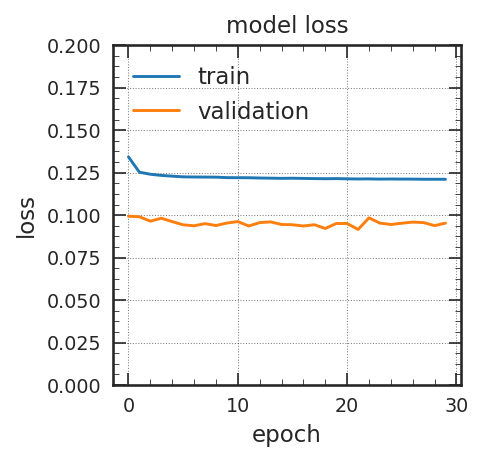

In [17]:
# Plot loss vs epoch
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_ylim(0,0.2)
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

# Because the last fraction of the sample only contains prompt, and
# the validation data come from the last fraction, they are all prompt.
# So the validation loss is always lower.

### Evaluate

In [18]:
# Because the last fraction of the sample only contains prompt, and
# the testing data come from the last fraction, they are all prompt.
# Need to include also the first fraction of the sample so that
# the testing data contain displaced muons.

old_num_samples = x_test.shape[0]
x_test = np.vstack((x_test, x_train[:old_num_samples]))
y_test = np.vstack((y_test, y_train[:old_num_samples]))
noise_test = np.vstack((noise_test, noise_train[:old_num_samples]))

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)
noise_test = noise_test.astype(np.float32)

In [19]:
loaded_model = load_my_model('model')

y_test_pred = loaded_model.predict(x_test, batch_size=4096)
print(y_test.shape, y_test_pred.shape)

(400000, 13) (400000, 13)


0
3 0.61468136 [False False False  True False False False False False False False False
 False]


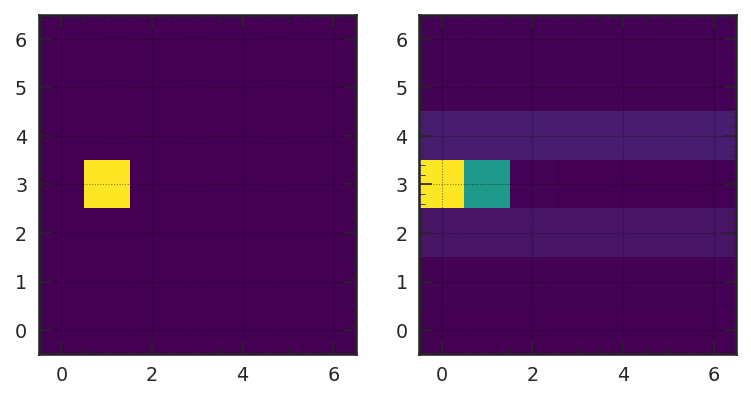

1
5 0.7515002 [False False False False False  True False False False False False False
 False]


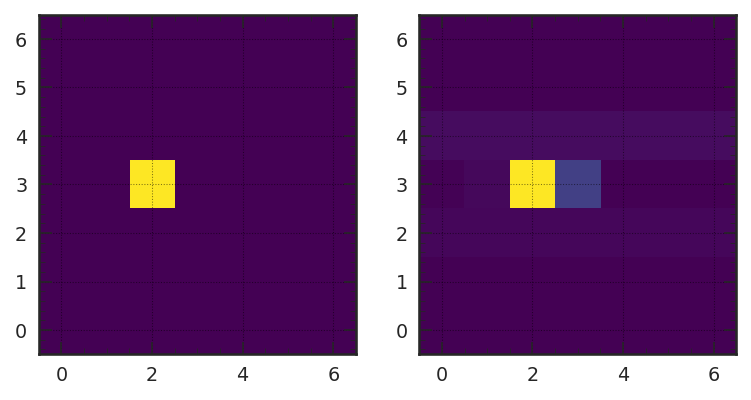

2
5 0.39309898 [False False False False False False False False False False False False
 False]


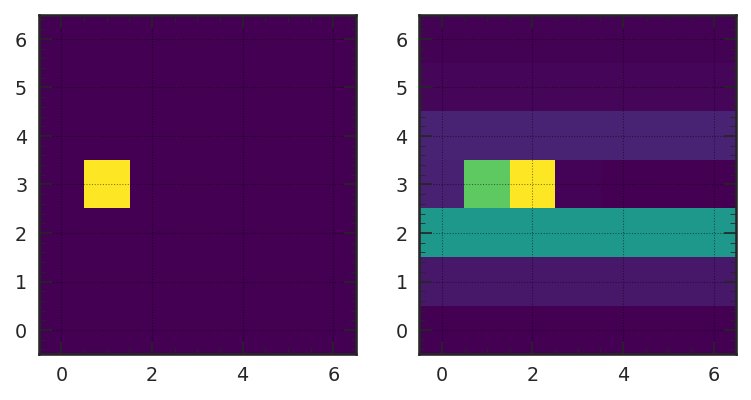

3
3 0.67462677 [False False False  True False False False False False False False False
 False]


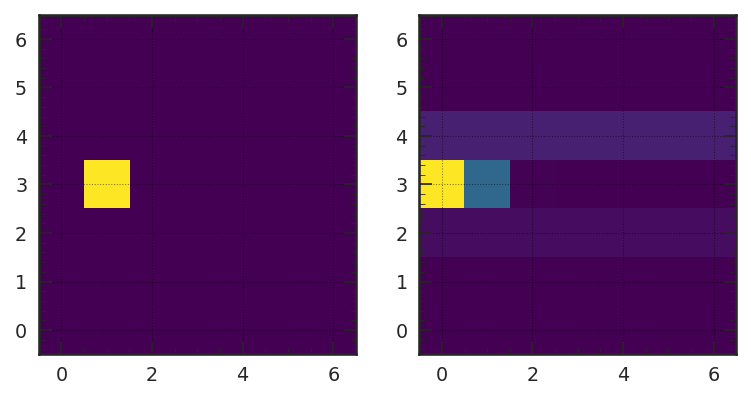

4
10 0.38606337 [False False False False False False False False False False False False
 False]


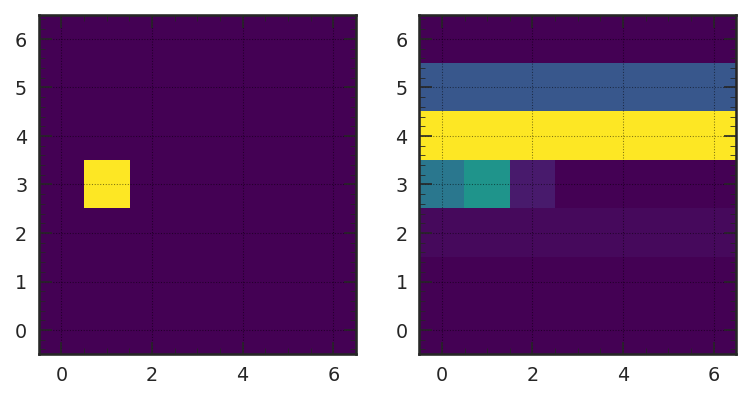

5
5 0.50855935 [False False False False False  True False False False False False False
 False]


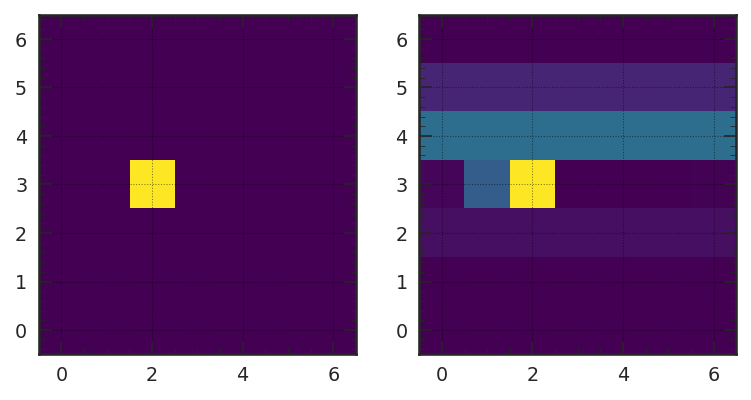

6
6 0.94480795 [False False False False False False  True False False False False False
 False]


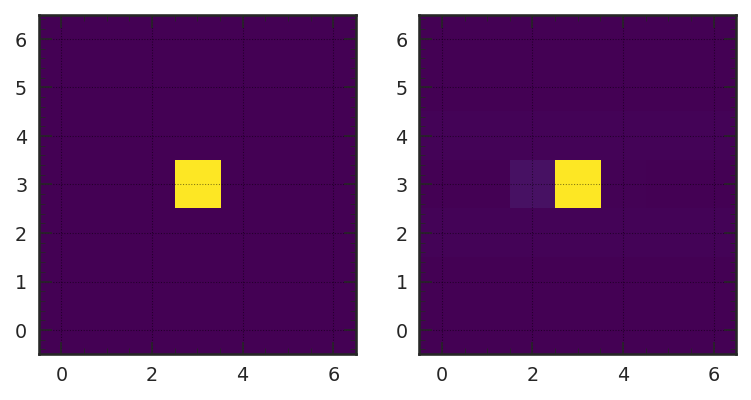

7
5 0.58120733 [False False False False False  True False False False False False False
 False]


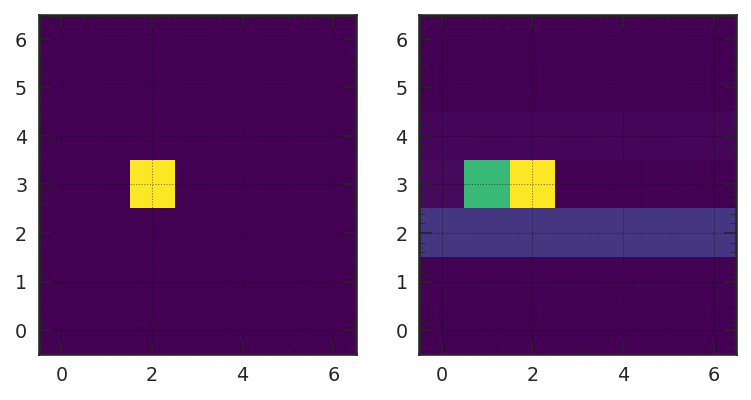

8
7 0.5517434 [False False False False False False False  True False False False False
 False]


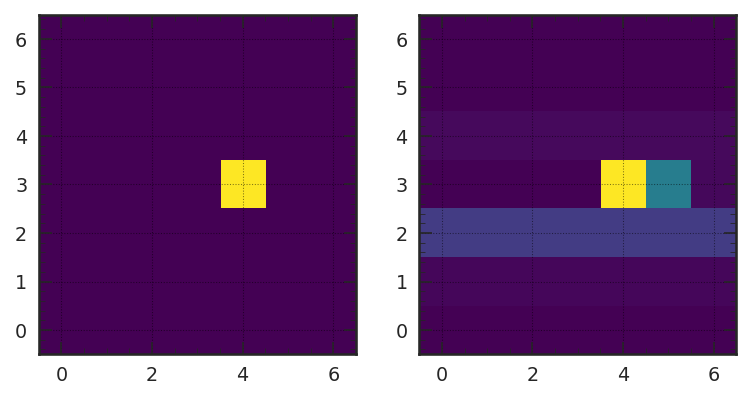

9
3 0.8517709 [False False False  True False False False False False False False False
 False]


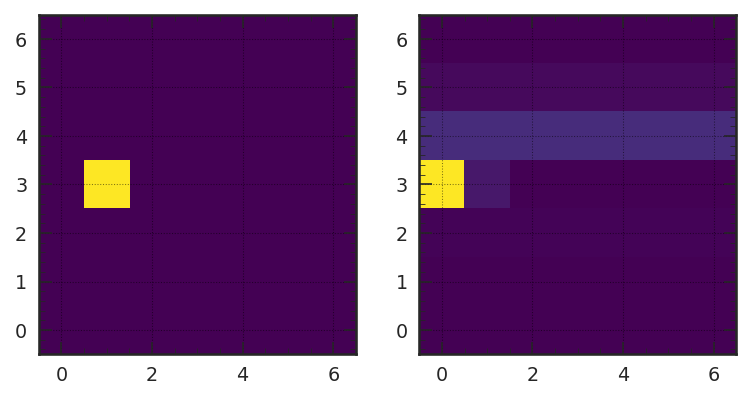

In [20]:
def convert_y_to_img(y):
  img = np.zeros((num_par_rows, num_par_cols), dtype=np.float32)
  img[0, :] = y[0]
  img[1, :] = y[1]
  img[2, :] = y[2]
  img[3, :] = y[[3, 4, 5, 6, 7, 8, 9]]
  img[4, :] = y[10]
  img[5, :] = y[11]
  img[6, :] = y[12]
  return img

for ievt in range(10):
  print(ievt)
  print(y_test_pred[ievt].argmax(), y_test_pred[ievt].max(), y_test_pred[ievt] > 0.5)
  fig, axs = plt.subplots(1, 2, figsize=(6,3))
  ax = axs[0]
  img = convert_y_to_img(y_test[ievt])
  ax.imshow(img, origin='lower', interpolation='none', aspect='auto')
  ax = axs[1]
  img = convert_y_to_img(y_test_pred[ievt])
  ax.imshow(img, origin='lower', interpolation='none', aspect='auto')
  plt.show()

6
6 0.94480795 [False False False False False False  True False False False False False
 False]


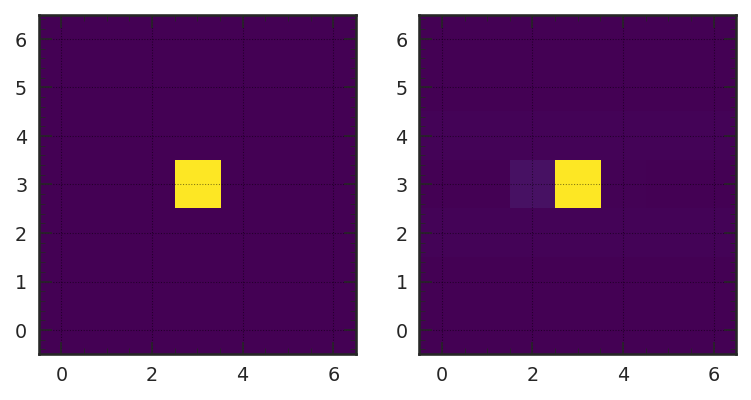

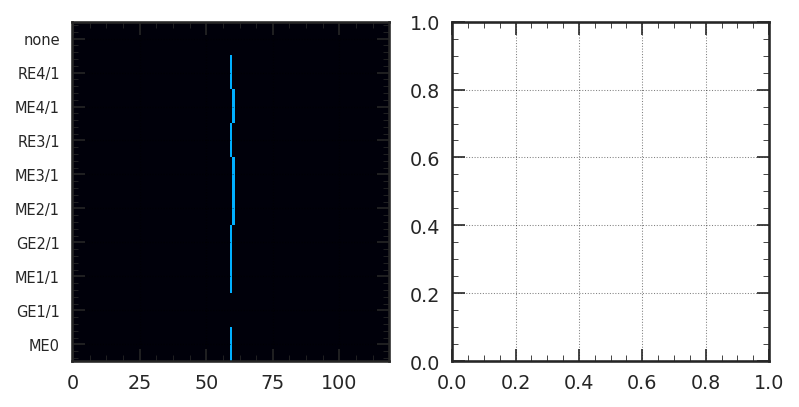

26
6 0.7601849 [False False False False False False  True False False False False False
 False]


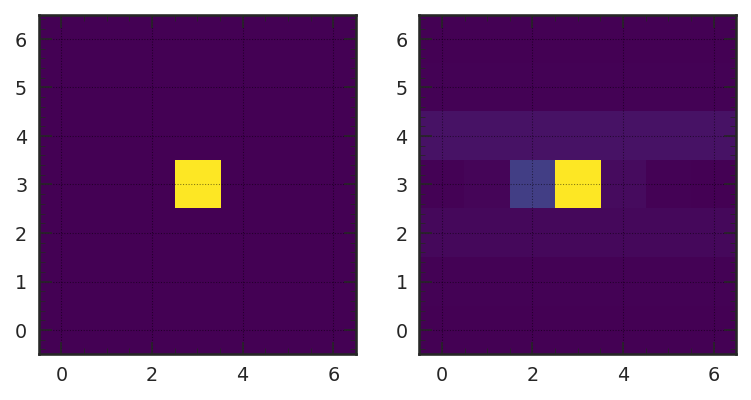

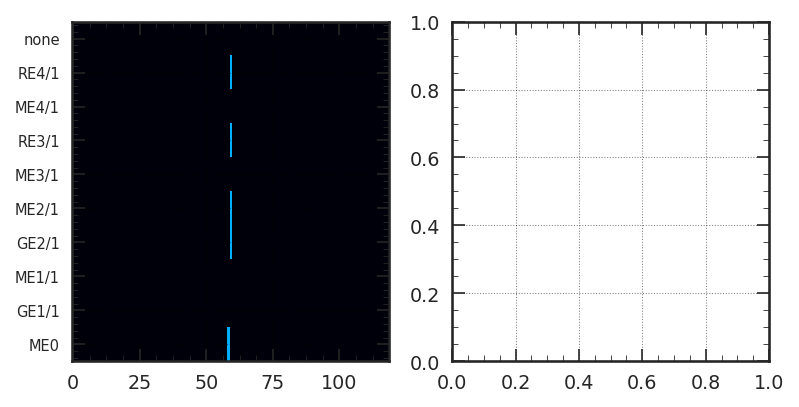

30
6 0.853385 [False False False False False False  True False False False False False
 False]


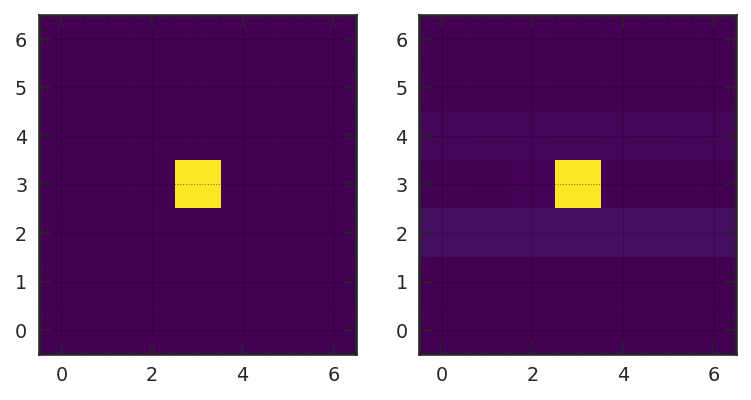

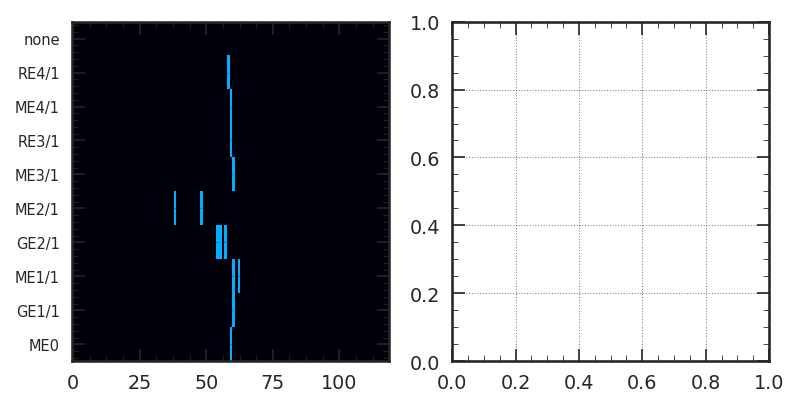

42
6 0.94702613 [False False False False False False  True False False False False False
 False]


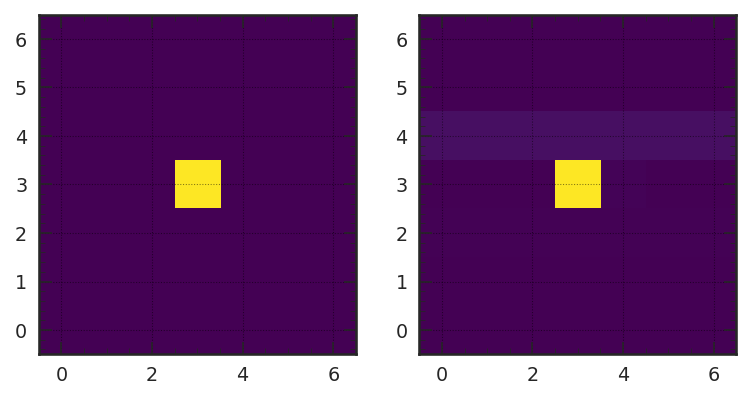

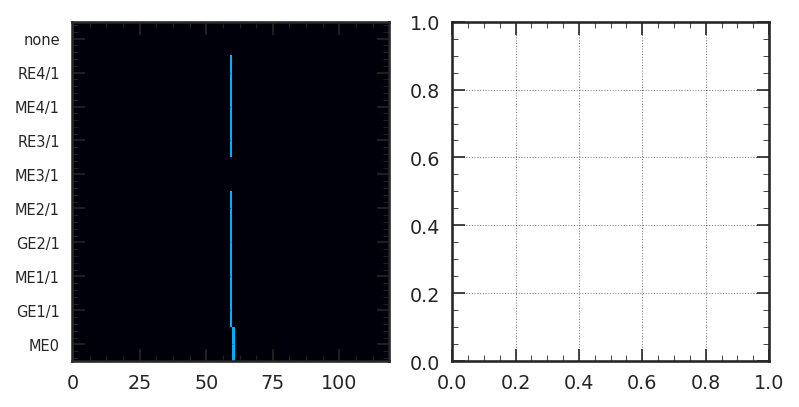

46
6 0.9679919 [False False False False False False  True False False False False False
 False]


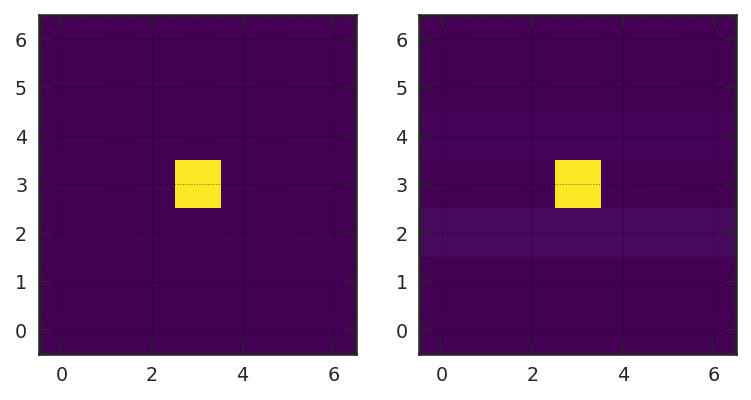

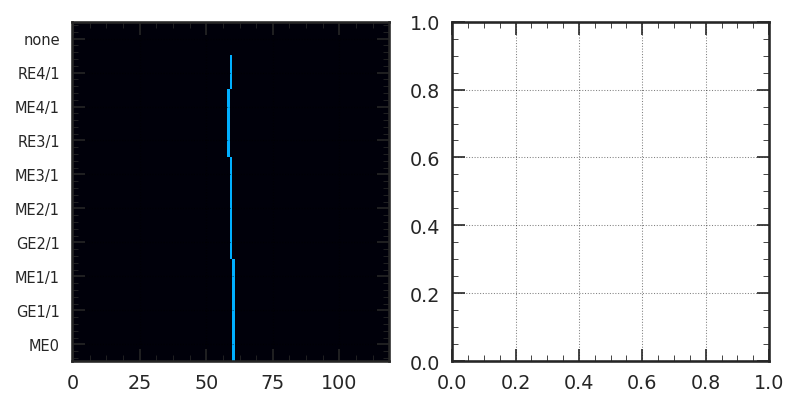

61
5 0.7383703 [False False False False False  True False False False False False False
 False]


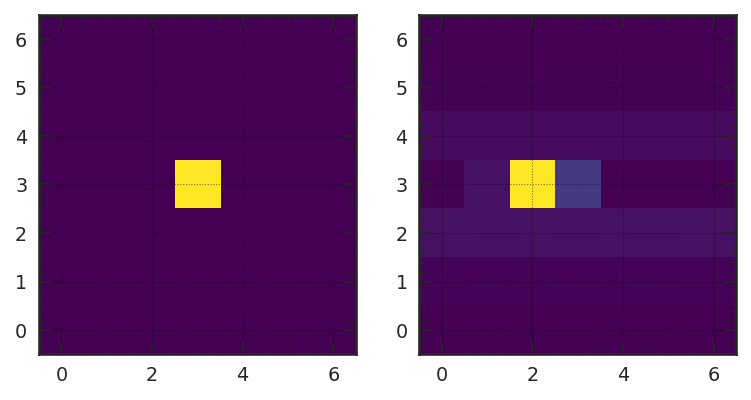

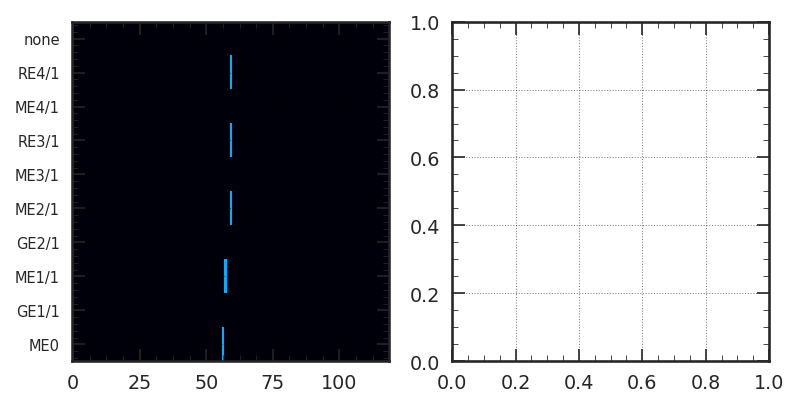

64
6 0.98686314 [False False False False False False  True False False False False False
 False]


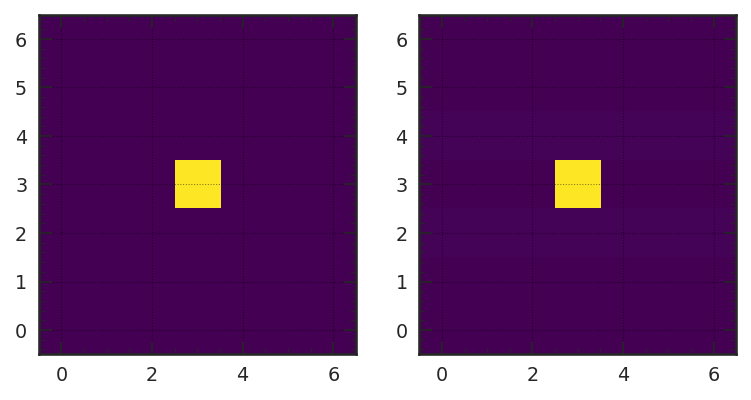

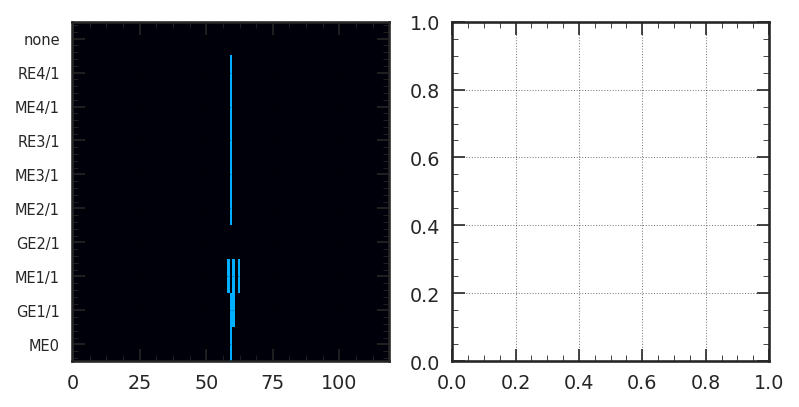

69
6 0.84777814 [False False False False False False  True False False False False False
 False]


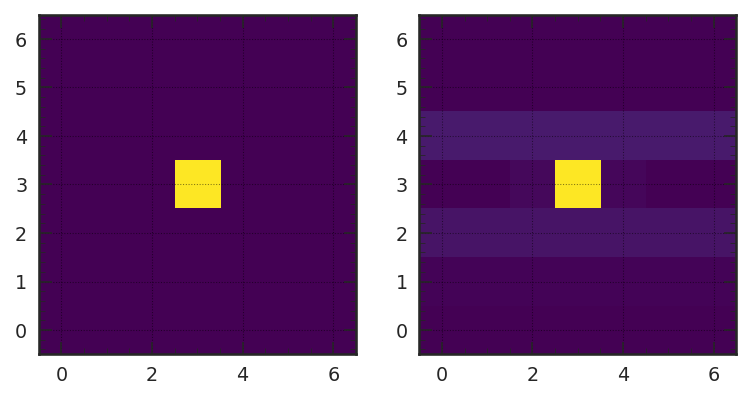

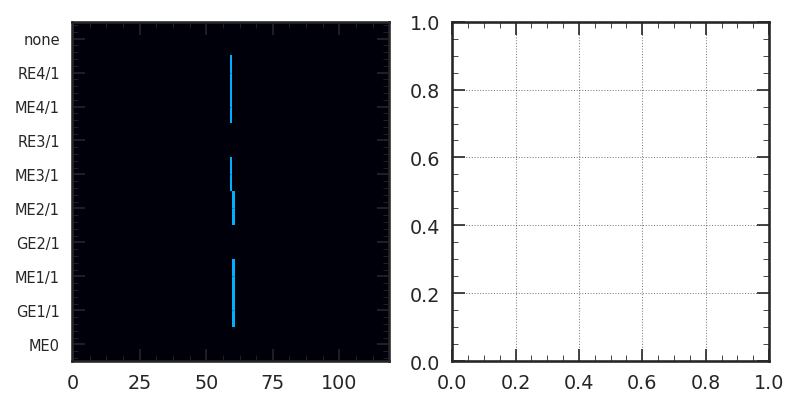

70
6 0.32951027 [False False False False False False False False False False False False
 False]


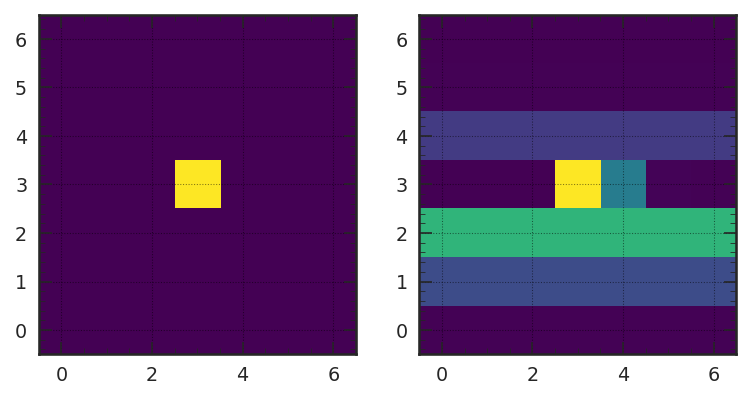

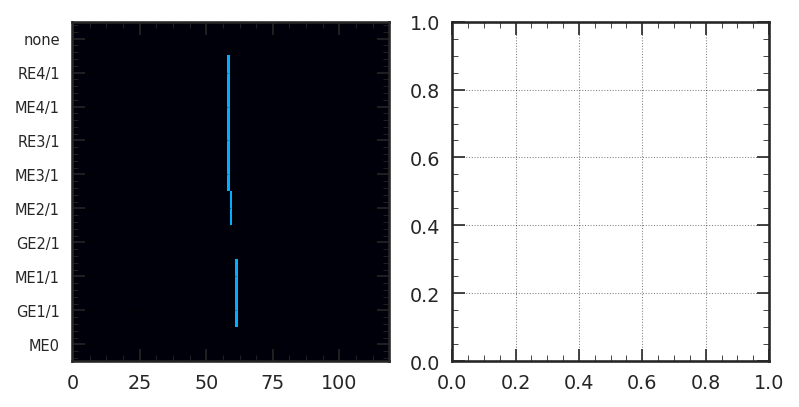

81
6 0.8808845 [False False False False False False  True False False False False False
 False]


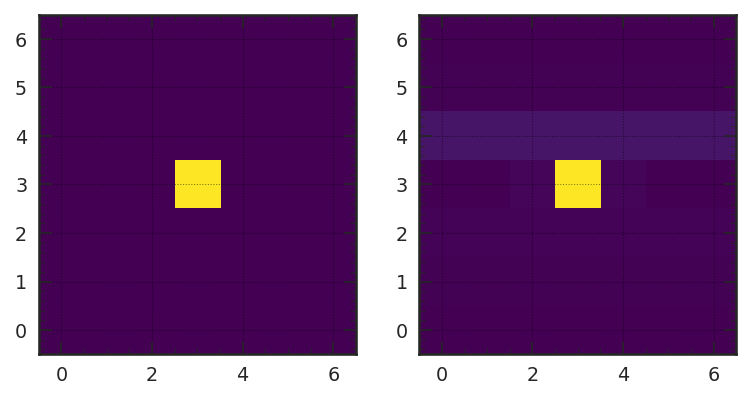

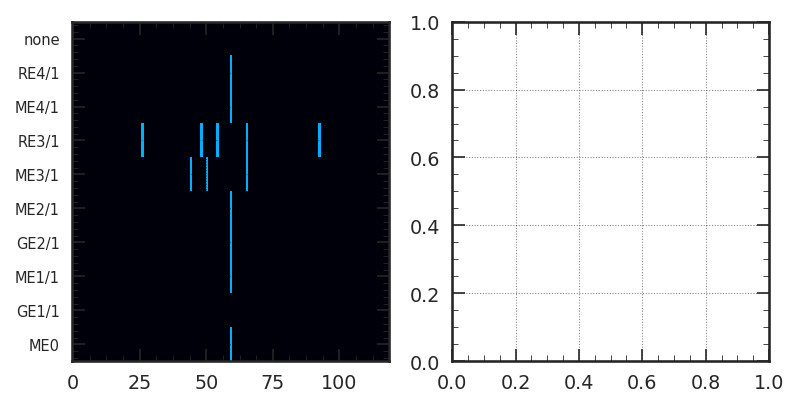

82
7 0.5804714 [False False False False False False False  True False False False False
 False]


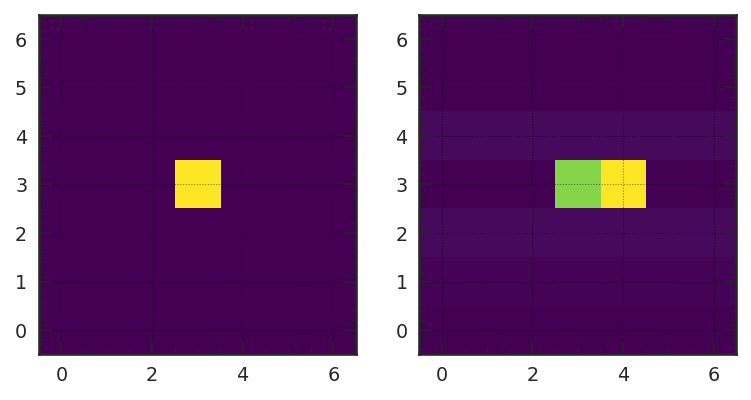

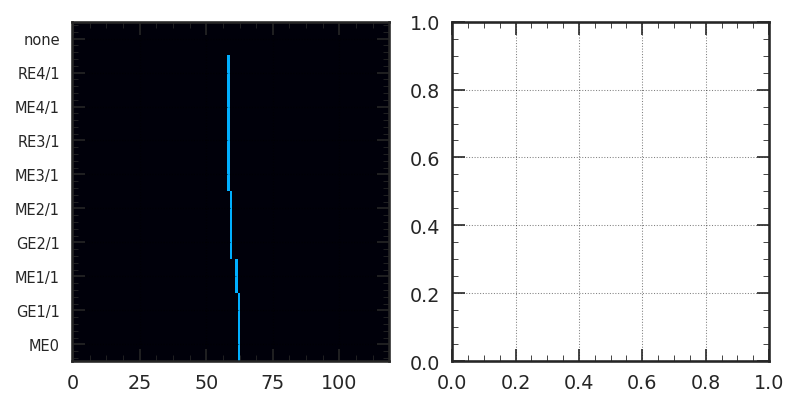

83
7 0.58605814 [False False False False False False False  True False False False False
 False]


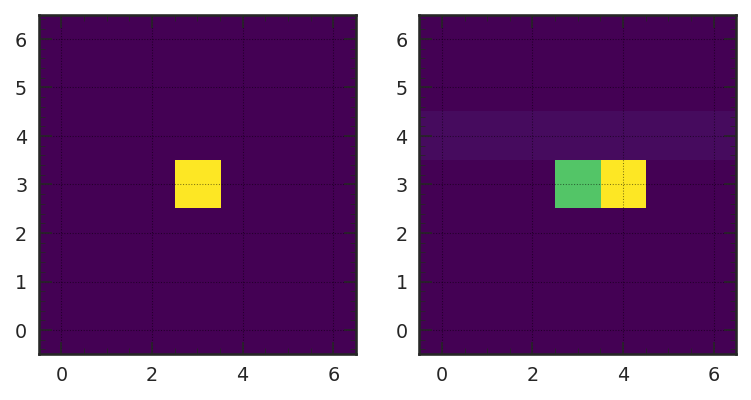

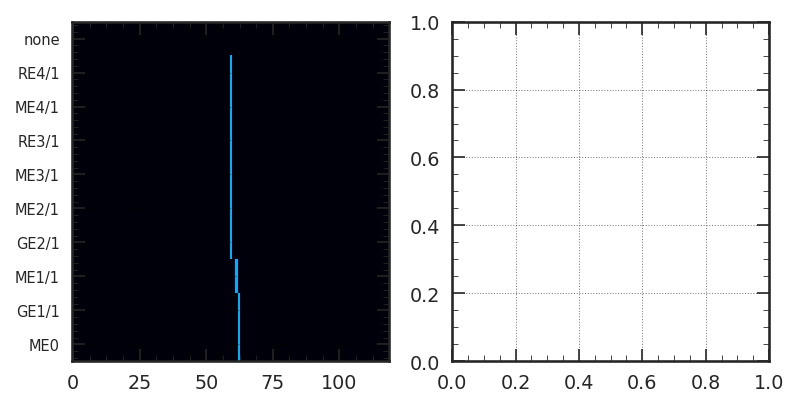

91
7 0.54803914 [False False False False False False False  True False False False False
 False]


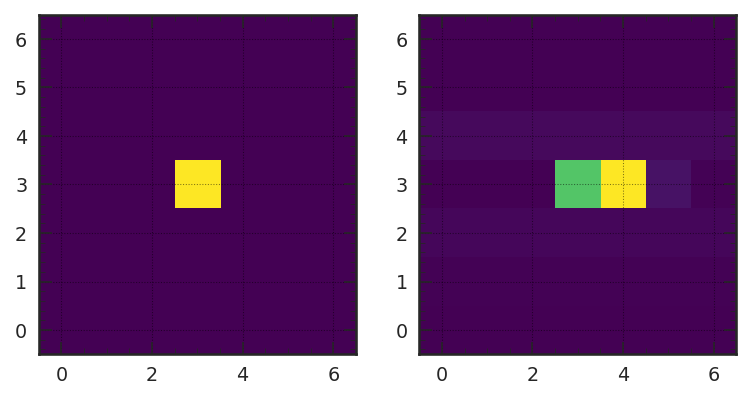

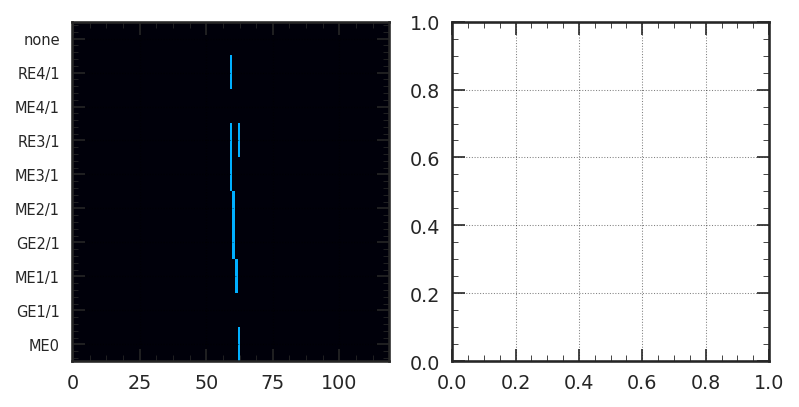

In [21]:
for ievt in range(100):
  # Only straight tracks
  if y_test[ievt][6] == 0:
    continue

  print(ievt)
  print(y_test_pred[ievt].argmax(), y_test_pred[ievt].max(), y_test_pred[ievt] > 0.5)
  fig, axs = plt.subplots(1, 2, figsize=(6,3))
  ax = axs[0]
  img = convert_y_to_img(y_test[ievt])
  ax.imshow(img, origin='lower', interpolation='none', aspect='auto')
  ax = axs[1]
  img = convert_y_to_img(y_test_pred[ievt])
  ax.imshow(img, origin='lower', interpolation='none', aspect='auto')
  plt.show()

  fig, axs = plt.subplots(1, 2, figsize=(6,3))
  ax = axs[0]
  ax.imshow(x_test[ievt][..., 0], origin='lower', interpolation='none', aspect='auto',
            cmap=blue_hot, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zone_row_labels[zone])))
  ax.set_yticklabels(zone_row_labels[zone], fontsize=7)
  #ax = axs[1]
  #ax.imshow(x_test[ievt][..., 0], origin='lower', interpolation='none', aspect='auto',
  #          cmap=blue_hot, vmin=0, vmax=1.6)
  plt.show()

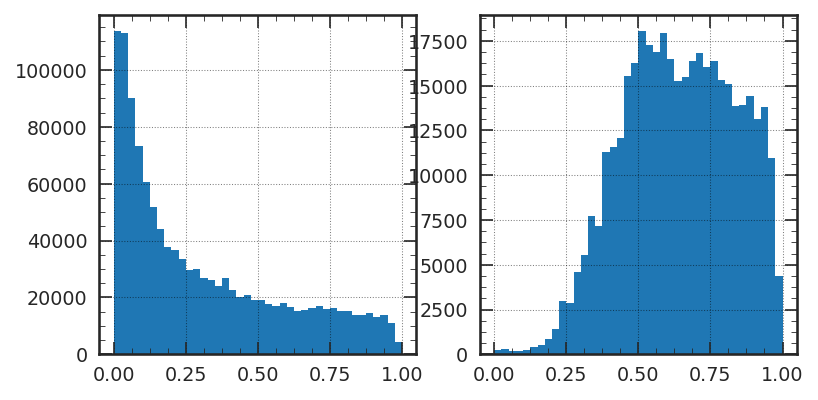

In [22]:
def find_top_k(arr, k=3):
  # Based on https://stackoverflow.com/q/6910641
  indices = np.argpartition(arr, -k)[-k:]
  return indices[np.argsort(arr[indices])][::-1]

activations_1 = []
activations_2 = []
for ievt in range(len(y_test)):
  for x in y_test_pred[ievt][find_top_k(y_test_pred[ievt])]:
    activations_1.append(x)
  for x in y_test_pred[ievt][find_top_k(y_test_pred[ievt], k=1)]:
    activations_2.append(x)

activations_1 = np.asarray(activations_1)
activations_2 = np.asarray(activations_2)

fig, axs = plt.subplots(1, 2, figsize=(6,3))
ax = axs[0]
ax.hist(activations_1, range=(0,1), bins=40)
ax = axs[1]
ax.hist(activations_2, range=(0,1), bins=40)
plt.show()

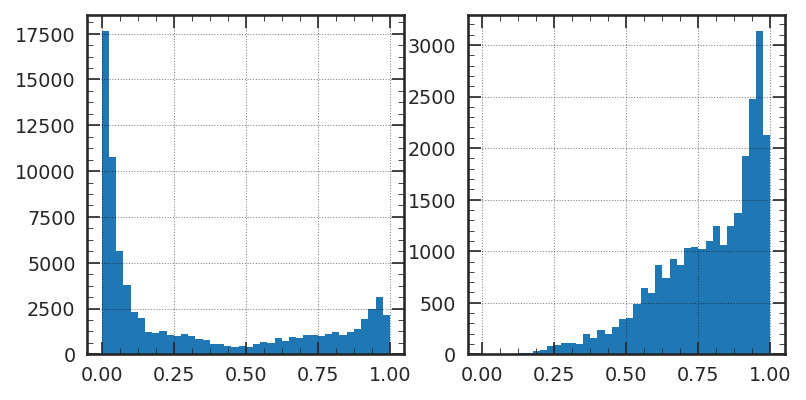

In [23]:
def find_top_k(arr, k=3):
  # Based on https://stackoverflow.com/q/6910641
  indices = np.argpartition(arr, -k)[-k:]
  return indices[np.argsort(arr[indices])][::-1]

activations_1 = []
activations_2 = []
for ievt in range(len(y_test)):
  # Only straight tracks
  if y_test[ievt][6] == 0:
    continue

  for x in y_test_pred[ievt][find_top_k(y_test_pred[ievt])]:
    activations_1.append(x)
  for x in y_test_pred[ievt][find_top_k(y_test_pred[ievt], k=1)]:
    activations_2.append(x)

activations_1 = np.asarray(activations_1)
activations_2 = np.asarray(activations_2)

fig, axs = plt.subplots(1, 2, figsize=(6,3))
ax = axs[0]
ax.hist(activations_1, range=(0,1), bins=40)
ax = axs[1]
ax.hist(activations_2, range=(0,1), bins=40)
plt.show()

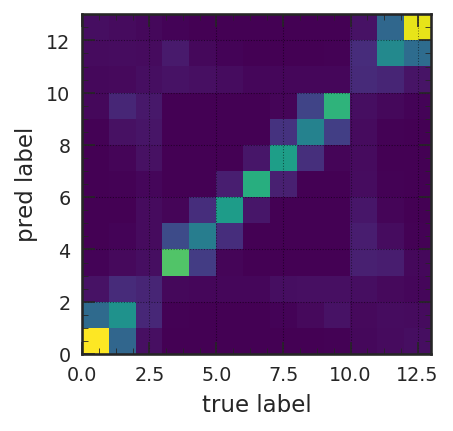

In [24]:
# Confusion matrix

num_classes = y_test.shape[1]

h = np.zeros((num_classes, num_classes), dtype=np.float32)
for ievt in range(len(y_test)):
  lab = unpack_singleton(np.nonzero(y_test[ievt]))
  h[lab, :] += y_test_pred[ievt]

fig, ax = plt.subplots(1, 1, figsize=(3,3))
xedges = np.arange(num_classes+1)
yedges = np.arange(num_classes+1)
_ = hist2d_on_binned_array(h.T, xedges, yedges, ax=ax, colorbar=False)
ax.set_xlabel(r'true label')
ax.set_ylabel(r'pred label')
plt.show()

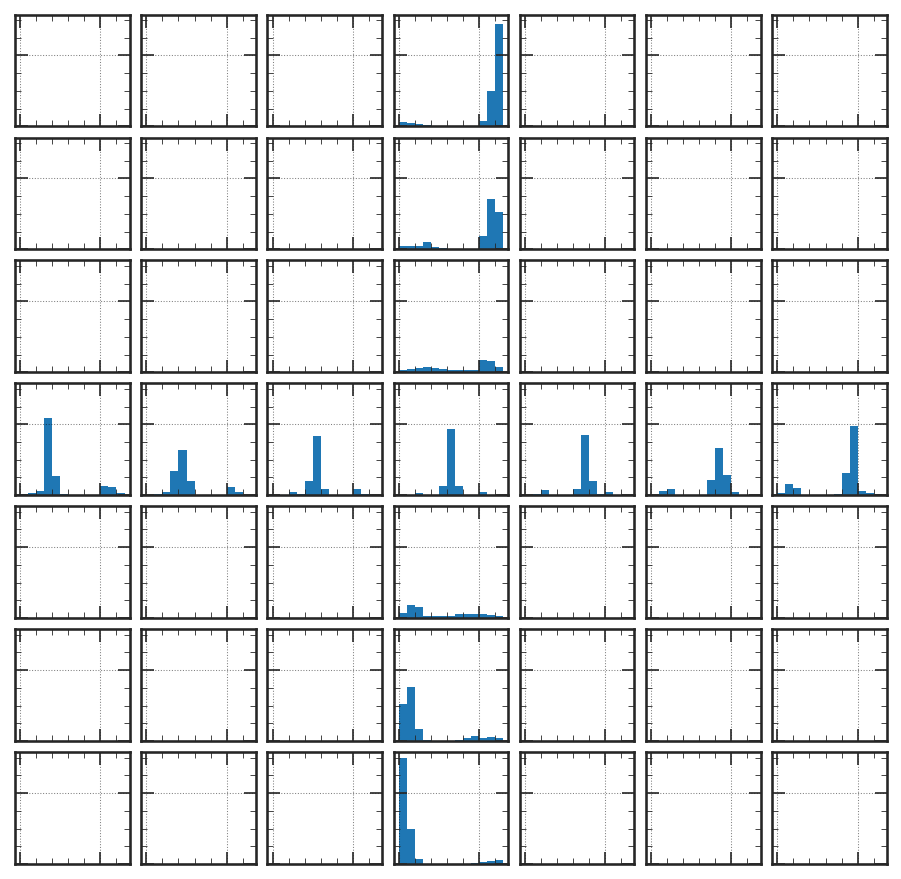

In [25]:
def convert_i_to_lab(i):
  lab = -1
  if (i == 0*num_par_cols + 3):
    lab = 0
  elif (i == 1*num_par_cols + 3):
    lab = 1
  elif (i == 2*num_par_cols + 3):
    lab = 2
  elif (3*num_par_cols + 0 <= i) and (i <= 3*num_par_cols + 6):
    lab = 3 + (i%num_par_cols)
  elif (i == 4*num_par_cols + 3):
    lab = 10
  elif (i == 5*num_par_cols + 3):
    lab = 11
  elif (i == 6*num_par_cols + 3):
    lab = 12
  return lab

fig, axs = plt.subplots(num_par_rows, num_par_cols, figsize=(7.5,7.5),
                        sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))
for i in range(num_par_rows * num_par_cols):
  ax = axs[(num_par_rows-1) - i//num_par_cols, i%num_par_cols]   # axs[0,0] is top left
  lab = convert_i_to_lab(i)
  if lab != -1:
    _ = hist_on_binned_array(h[lab], xedges, ax=ax)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
plt.show()

In [26]:
# Activation maps

x_test_dummy = np.zeros((num_box_rows * num_box_cols, num_box_rows, num_box_cols, num_box_channels), dtype=np.float32)

for ievt in range(len(x_test_dummy)):
  row, col = (ievt//num_box_cols), (ievt%num_box_cols)
  x_test_dummy[ievt][row, col] = 1

y_test_dummy = loaded_model.predict(x_test_dummy, batch_size=4096)

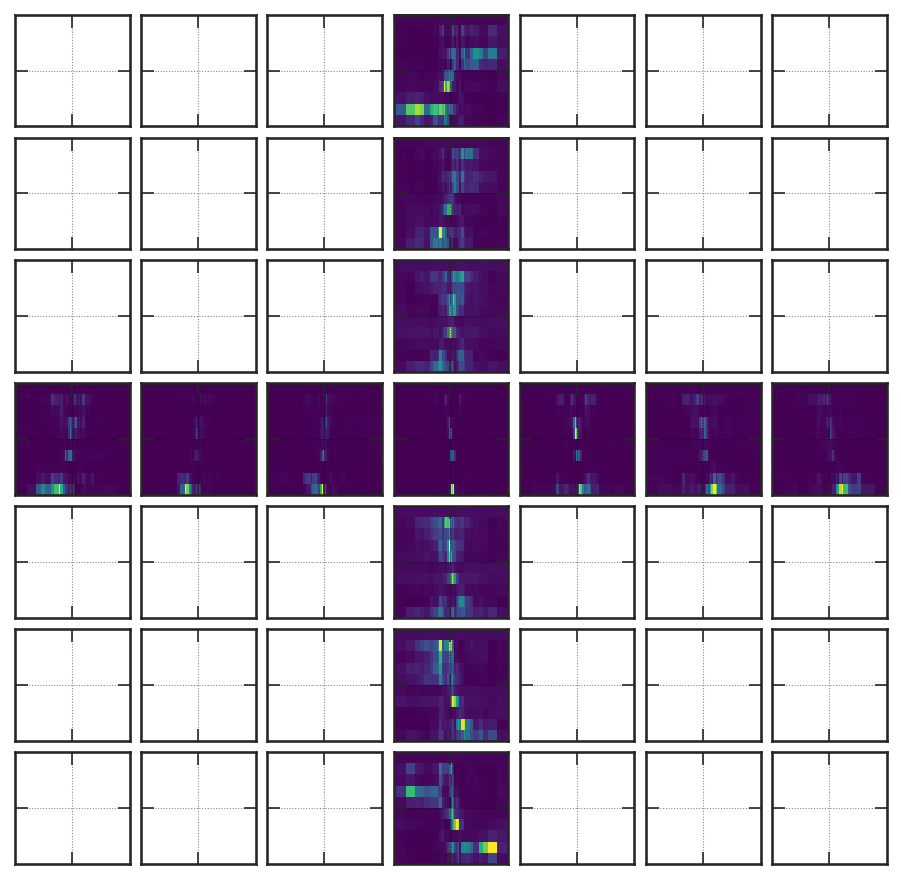

In [27]:
fig, axs = plt.subplots(num_par_rows, num_par_cols, figsize=(7.5,7.5),
                        sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))
for i in range(num_par_rows * num_par_cols):
  ax = axs[(num_par_rows-1) - i//num_par_cols, i%num_par_cols]   # axs[0,0] is top left
  lab = convert_i_to_lab(i)
  if lab != -1:
    xedges = np.arange(num_box_cols+1)
    yedges = np.arange(num_box_rows+1)
    h = y_test_dummy[..., lab].reshape(num_box_rows, num_box_cols)
    _ = hist2d_on_binned_array(h.T, xedges, yedges, ax=ax, colorbar=False)
  ax.set_xticks([59])
  ax.set_yticks([5])
  ax.set_xticklabels([])
  ax.set_yticklabels([])
plt.show()

In [28]:
h = y_test_dummy[..., 6].reshape(num_box_rows, num_box_cols)
print(h.shape, h.max(), np.nonzero(h > 0.01))

(10, 119) 0.01038599 (array([0]), array([61]))


### Inspect model

In [29]:
model_weights_w_names = {}

model_weights = loaded_model.get_weights()
#print(len(model_weights))

i = 0
for model_layer in loaded_model.layers:
  if model_layer.weights:
    for _ in model_layer.weights:
      print(i, model_layer.name, model_weights[i].shape)
      model_weights_w_names.setdefault(model_layer.name, []).append(model_weights[i])
      i += 1

if False:
  for k, v in model_weights_w_names.iteritems():
    #print(k, v)
    print(k, [x.shape for x in v])

0 conv2d_1 (10, 5, 1, 5)
1 conv2d_2 (10, 5, 1, 5)
2 conv2d_3 (10, 5, 1, 5)
3 conv2d_4 (10, 5, 1, 5)
4 conv2d_5 (10, 5, 1, 5)
5 conv2d_6 (10, 5, 1, 5)
6 conv2d_7 (10, 5, 1, 5)
7 batch_normalization_1 (5,)
8 batch_normalization_1 (5,)
9 batch_normalization_1 (5,)
10 batch_normalization_2 (5,)
11 batch_normalization_2 (5,)
12 batch_normalization_2 (5,)
13 batch_normalization_3 (5,)
14 batch_normalization_3 (5,)
15 batch_normalization_3 (5,)
16 batch_normalization_4 (5,)
17 batch_normalization_4 (5,)
18 batch_normalization_4 (5,)
19 batch_normalization_5 (5,)
20 batch_normalization_5 (5,)
21 batch_normalization_5 (5,)
22 batch_normalization_6 (5,)
23 batch_normalization_6 (5,)
24 batch_normalization_6 (5,)
25 batch_normalization_7 (5,)
26 batch_normalization_7 (5,)
27 batch_normalization_7 (5,)
28 conv2d_8 (7, 1, 5, 21)
29 batch_normalization_8 (21,)
30 batch_normalization_8 (21,)
31 batch_normalization_8 (21,)
32 conv2d_9 (1, 1, 21, 13)
33 conv2d_9 (13,)


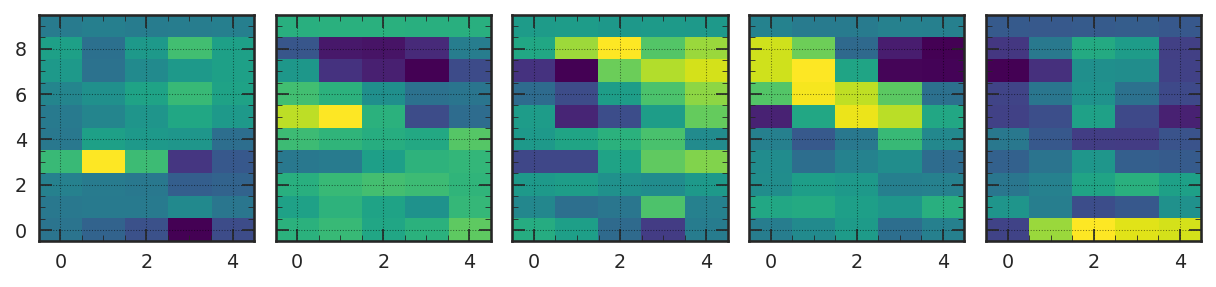

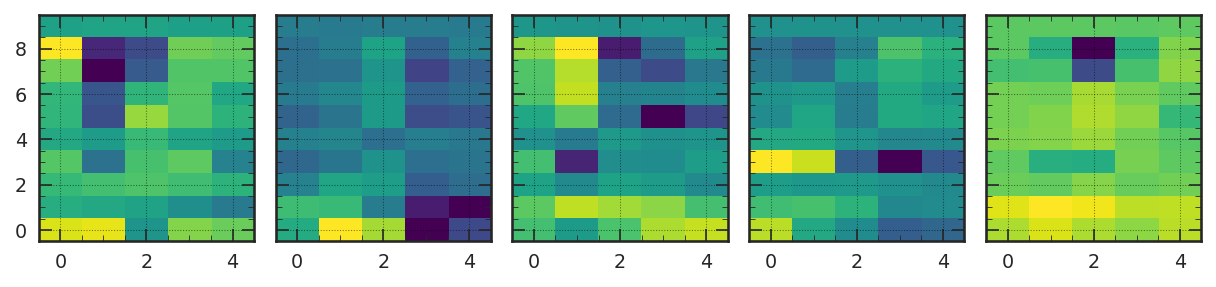

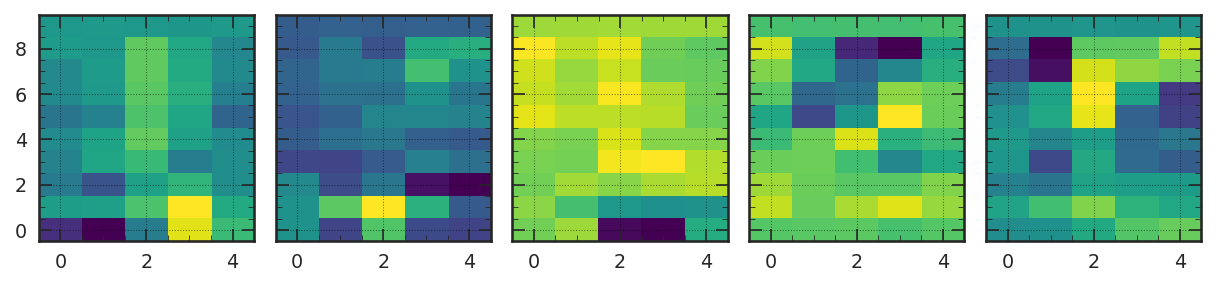

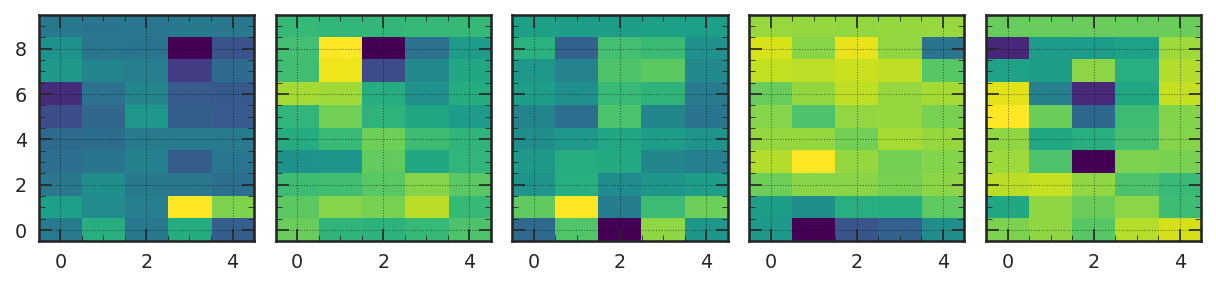

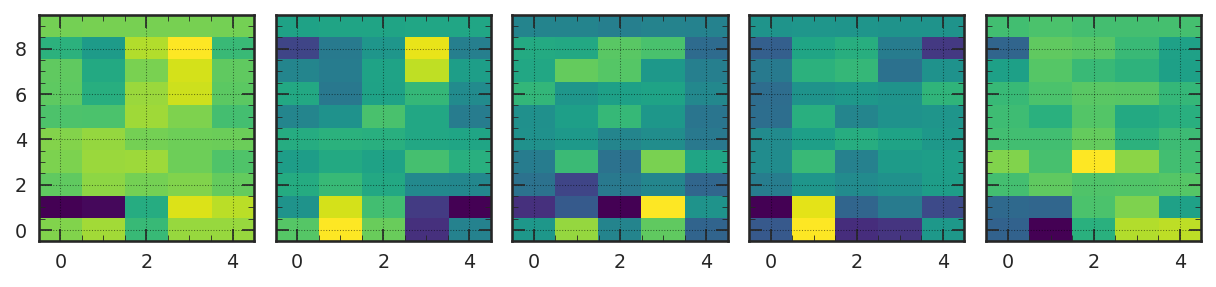

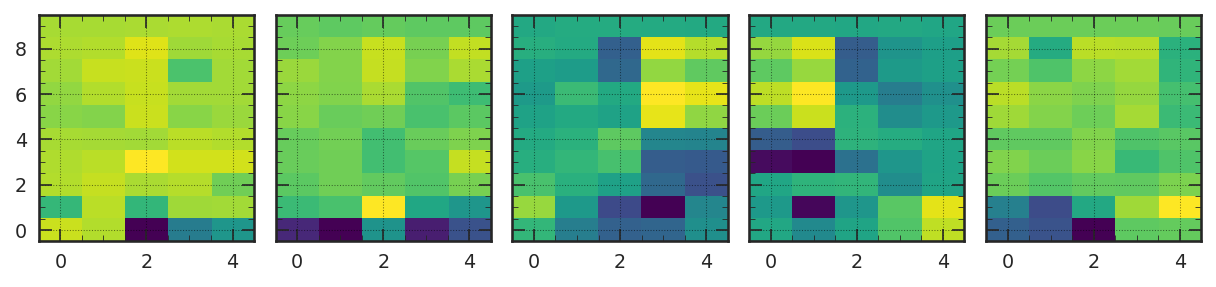

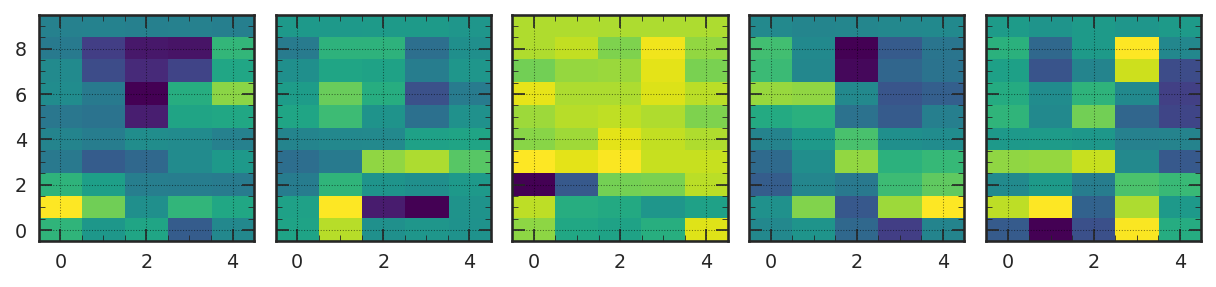

In [30]:
num_filters = 5

for conv in ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7']:
  fig, axs = plt.subplots(1, num_filters, figsize=(2*num_filters, 2),
                          sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))
  for i in range(num_filters):
    ax = axs[i]
    img = model_weights_w_names[conv][0][..., 0, i]
    ax.imshow(img, origin='lower', interpolation='none', aspect='auto')
  plt.show()

In [31]:
dummy_model = k_models.Model(loaded_model.input, loaded_model.get_layer('concatenate_1').output)

dummy_activations = dummy_model.predict(x_test, batch_size=4096)
print(dummy_activations.shape)

(400000, 7, 1, 5)


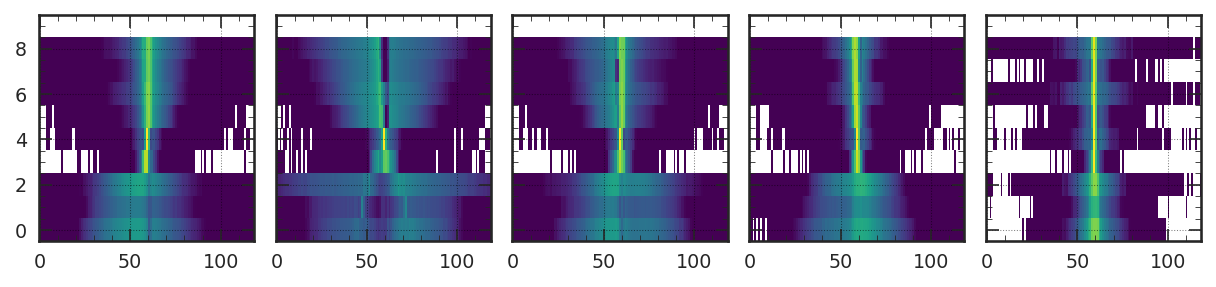

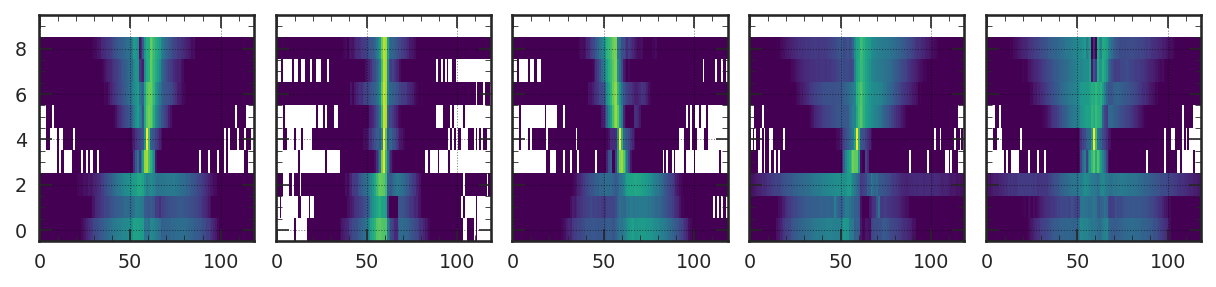

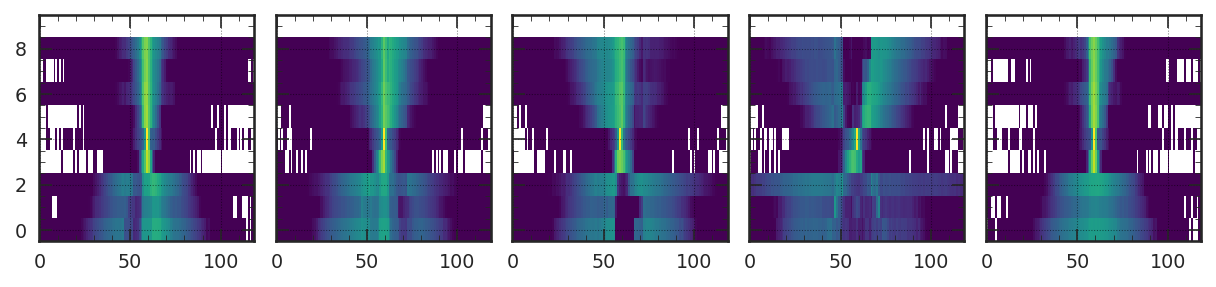

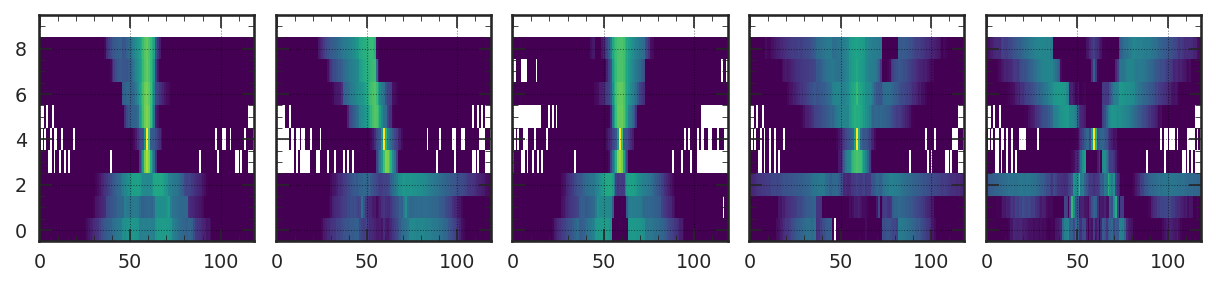

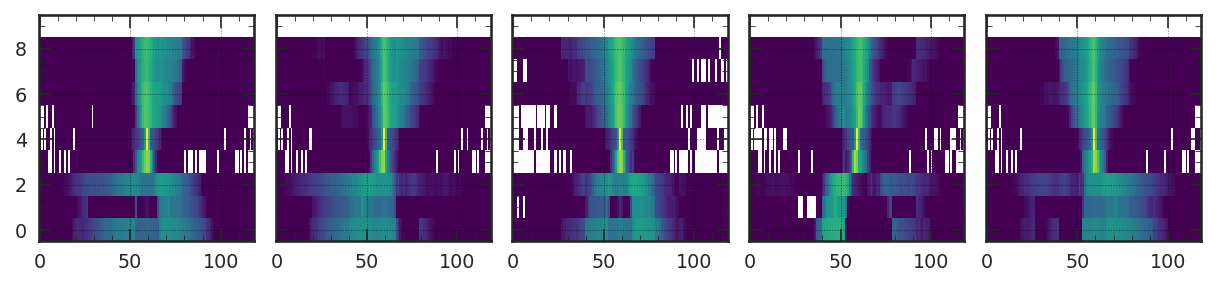

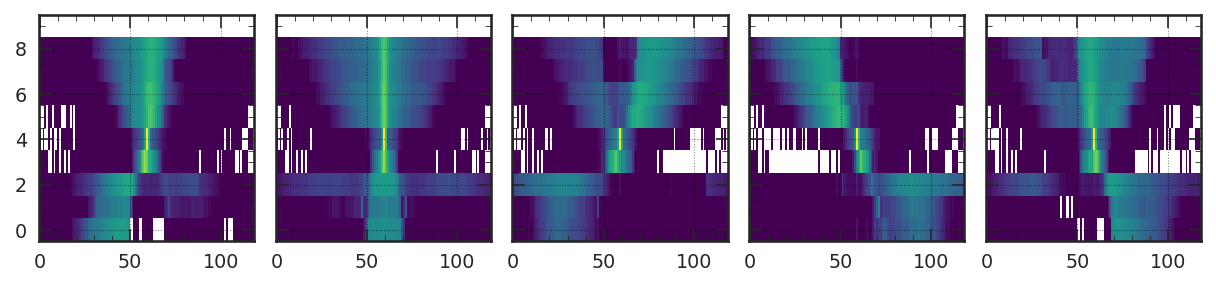

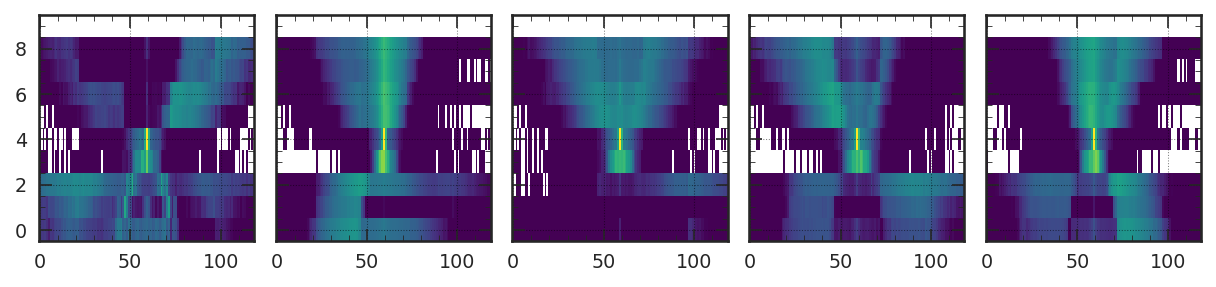

In [32]:
for j in range(dummy_activations.shape[1]):
  fig, axs = plt.subplots(1, num_filters, figsize=(2*num_filters, 2),
                          sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))
  for i in range(num_filters):
    ax = axs[i]
    img = (x_test * dummy_activations[:, j, 0, i].reshape(-1, 1, 1, 1)).sum(axis=0)
    img = img[..., 0]
    ax.imshow(img, origin='lower', interpolation='none', aspect='auto',
             norm=mpl.colors.LogNorm(img.max()*0.001, img.max()))
  plt.show()

In [33]:
#FIXME: Add image augmentation (flip, shift, minor shift) at start of every epoch
#FIXME: Add pileup mixing
#FIXME: Add mirror image processing
#FIXME: Use binary CNN
#FIXME: visualize kernels